In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import glob
from torchvision import transforms
from torch.utils import data
from PIL import Image

In [2]:
imgs = glob.glob(r'./dataset2/*.jpg')
print(imgs[:3])

species = ['cloudy', 'rain', 'shine', 'sunrise']  # 4种类别名称

# 字典推导式获取类别到编号的字典
species_to_idx = dict((c, i) for i, c in enumerate(species))
print(species_to_idx)

# 字典推到是获取编号到类别的字典
idx_to_species = dict((v, k) for k, v in species_to_idx.items())
print(idx_to_species)

labels = []
for img in imgs:
    for i, c in enumerate(species):
        if c in img:
            labels.append(i)
print(labels[:3])

['./dataset2\\cloudy1.jpg', './dataset2\\cloudy10.jpg', './dataset2\\cloudy100.jpg']
{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}
{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}
[0, 0, 0]


In [3]:
transform=transforms.Compose([
    transforms.Resize((96,96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
])

In [4]:
class WT_dataset(data.Dataset):
    def __init__(self, imgs_path, labels):
        self.imgs_path = imgs_path
        self.labels = labels

    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        label = self.labels[index]

        pil_img = Image.open(img_path)
        pil_img = pil_img.convert("RGB")  # 此行可选，如有黑白图片会被转为RGB格式
        pil_img = transform(pil_img)
        return pil_img, label

    def __len__(self):
        return len(self.imgs_path)


In [5]:
dataset=WT_dataset(imgs,labels)
count=len(dataset)
print(count) #打印数据集大小，显示为1120

1122


In [6]:
train_count=int(0.8*count)
test_count=count-train_count
#划分训练数据和测试数据
train_dataset,test_dataset=data.random_split(dataset,[train_count,test_count])
print(len(train_dataset),len(test_dataset))

897 225


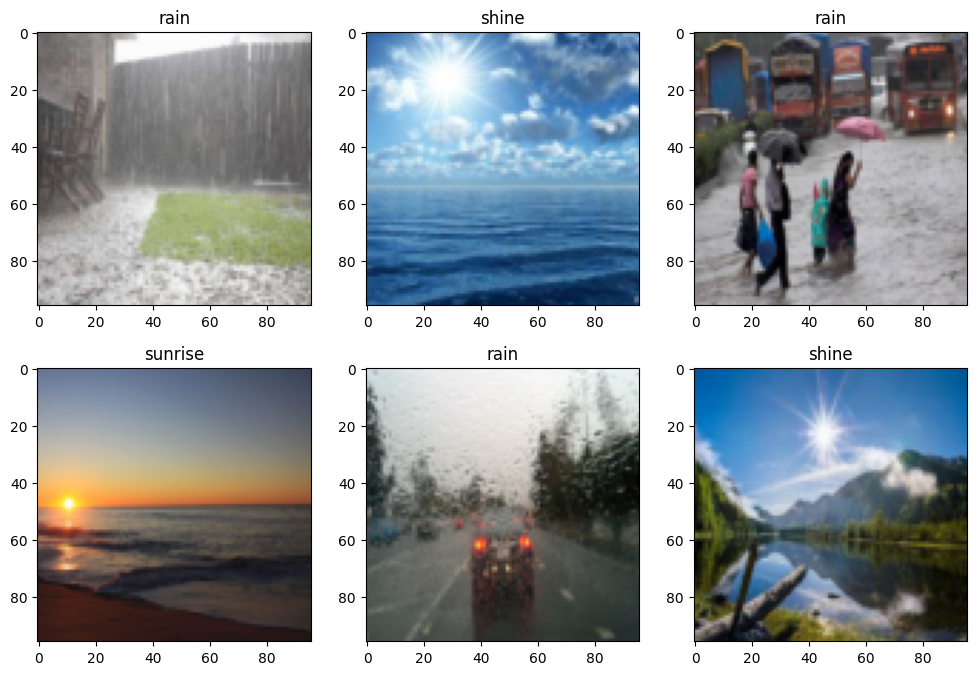

In [7]:
BTACH_SIZE=16#批次大小
train_dl=torch.utils.data.DataLoader(
                                    train_dataset,
                                    batch_size=BTACH_SIZE,
                                    shuffle=True)
test_dl=torch.utils.data.DataLoader(test_dataset,
                                   batch_size=BTACH_SIZE)

imgs_batch,labels_batch=next(iter(train_dl))
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(imgs_batch[:6],labels_batch[:6])):
    # 设置channel最后
    img=(img.permute(1,2,0).numpy()+1)/2
    plt.subplot(2,3,i+1)
    plt.title(idx_to_species.get(label.item()))
    plt.imshow(img)
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,16,3)
        self.conv2=nn.Conv2d(16,32,3)
        self.conv3=nn.Conv2d(32,64,3)
        self.fc1=nn.Linear(64*10*10,1024)
        self.fc2=nn.Linear(1024,4)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(x,2)
        x=x.view(-1,64*10*10)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x

device="cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=Net().to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

Using cuda device


In [9]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)  # 获取当前数据集样本总数量
    num_batches=len(dataloader)  #获得当前dataloader总批次数
    # train_loss用于累计所有批次的损失之和，correct用于累计预测正确的样本总数
    train_loss,correct=0,0
    for X,y in dataloader:  #对dataloader进行迭代
        X,y=X.to(device),y.to(device)  #每一批次的数据设置为使用当前device进行预测，并计算一个批次的损失
        pred=model(X)
        loss=loss_fn(pred,y)  # 返回的是平均损失
        #使用反向传播算法，根据损失优化模型参数
        optimizer.zero_grad()  #将模型参数的梯度全部归零
        loss.backward()  # 损失反向传播，计算模型参数梯度
        optimizer.step()  # 根据梯度优化参数
        with torch.no_grad():
            # correct 用于累计预测正确的样本总数
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
            #train_loss用于累计所有批次的损失之和
            train_loss+=loss.item()
    #train_loss是所有批次的损失之和，所以计算全部样本的平均损失时需要处于总批次数
    train_loss/=num_batches
    #correct是预测正确的样本总是，若计算整个epoch总体正确率，需除以样本总数量
    correct/=size
    return train_loss,correct

In [10]:
def test(dataloader,model):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    test_loss,correct=0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=num_batches
    correct/=size
    return test_loss,correct

epoch: 0,train_loss:0.70863,train_acc:72.2%,test_loss:0.48350,test_acc:83.1%
epoch: 1,train_loss:0.46491,train_acc:83.4%,test_loss:0.38429,test_acc:83.6%
Done!


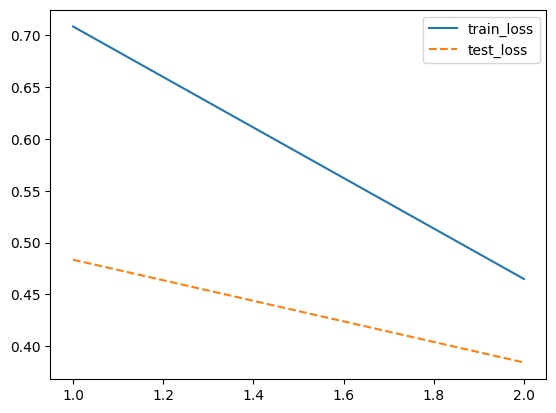

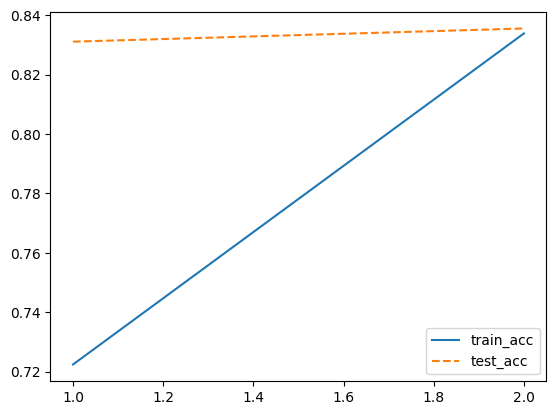

In [11]:
epochs= 2 #一个epoch代表对全部数据训练一遍

train_loss=[]  #每个epoch训练中训练数据集的平均损失被添加到此列表
train_acc=[] #每个epoch训练中训练数据集的平均正确率被添加到此列表
test_loss=[]  #每个epoch训练中测试数据集的平均损失被添加到此列表
test_acc=[] #每个epoch训练中测试数据集的平均正确率被添加到此列表

for epoch in range(epochs):
    #调用train()函数训练
    epoch_loss,epoch_acc=train(train_dl,model,loss_fn,optimizer)
    #调用test()函数测试
    epoch_test_loss,epoch_test_acc=test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    #定义一个打印模版
    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
    #输出当前的epoch的训练集损失、训练集正确率、测试集损失、测试集正确率
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
    
print("Done!")

plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss',ls="--")
plt.legend()
plt.show()

plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc',ls="--")
plt.legend()
plt.show()

In [12]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    train_loss,correct=0,0
    model.train()  # 模型为训练模式
    for X,y in dataloader:
        X,y=X.to(device),y.to(device)
        #计算损失
        pred=model(X)
        loss=loss_fn(pred,y)
        #反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
            train_loss+=loss.item()
    train_loss/=num_batches
    correct/=size
    return train_loss,correct

def test(dataloader,model):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()   # 模式为预测模式
    test_loss,correct=0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=num_batches
    correct/=size
    return test_loss,correct

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  #继承nn.Module的父类
        self.conv1=nn.Conv2d(3,16,3)
        self.conv2=nn.Conv2d(16,32,3)
        self.conv3=nn.Conv2d(32,64,3)
        self.fc1=nn.Linear(64*10*10,1024)
        self.fc2=nn.Linear(1024,4)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(x,2)
        x=x.view(-1,64*10*10)
        x=F.dropout(x)  #Dropout层，使用默认比例p=0.5
        x=F.relu(self.fc1(x))
        x=F.dropout(x)  #Dropout层，使用默认比例p=0.5
        x=self.fc2(x)
        return x

device="cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=Net().to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

Using cuda device


epoch: 0,train_loss:0.76965,train_acc:65.6%,test_loss:0.60010,test_acc:77.3%
epoch: 1,train_loss:0.48665,train_acc:83.3%,test_loss:0.47244,test_acc:77.8%
epoch: 2,train_loss:0.45043,train_acc:82.3%,test_loss:0.44006,test_acc:80.9%
epoch: 3,train_loss:0.39300,train_acc:85.1%,test_loss:0.53495,test_acc:72.9%
epoch: 4,train_loss:0.35296,train_acc:86.8%,test_loss:0.40360,test_acc:81.8%
epoch: 5,train_loss:0.30089,train_acc:88.3%,test_loss:0.33960,test_acc:85.8%
epoch: 6,train_loss:0.26461,train_acc:90.5%,test_loss:0.30751,test_acc:88.0%
epoch: 7,train_loss:0.26677,train_acc:90.9%,test_loss:0.33749,test_acc:87.1%
epoch: 8,train_loss:0.21876,train_acc:92.0%,test_loss:0.30657,test_acc:86.7%
epoch: 9,train_loss:0.19403,train_acc:92.8%,test_loss:0.33228,test_acc:85.8%
Done!


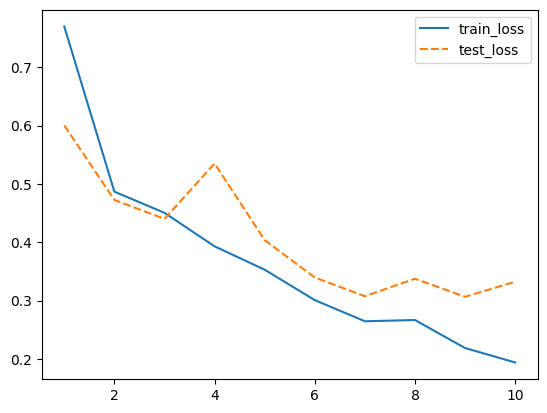

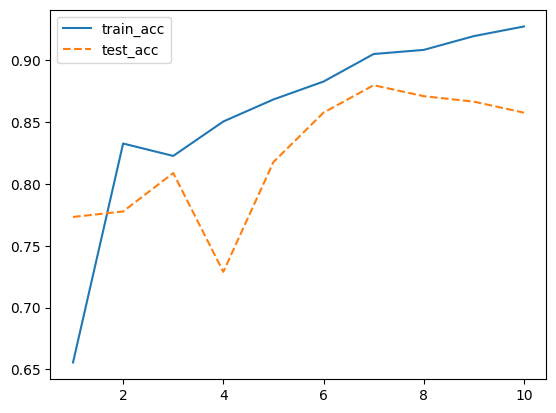

In [14]:
epochs= 10 #一个epoch代表对全部数据训练一遍

train_loss=[]  #每个epoch训练中训练数据集的平均损失被添加到此列表
train_acc=[] #每个epoch训练中训练数据集的平均正确率被添加到此列表
test_loss=[]  #每个epoch训练中测试数据集的平均损失被添加到此列表
test_acc=[] #每个epoch训练中测试数据集的平均正确率被添加到此列表

for epoch in range(epochs):
    #调用train()函数训练
    epoch_loss,epoch_acc=train(train_dl,model,loss_fn,optimizer)
    #调用test()函数测试
    epoch_test_loss,epoch_test_acc=test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    #定义一个打印模版
    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
    #输出当前的epoch的训练集损失、训练集正确率、测试集损失、测试集正确率
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
    
print("Done!")

plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss',ls="--")
plt.legend()
plt.show()

plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc',ls="--")
plt.legend()
plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()  #继承nn.Module的父类
        self.conv1=nn.Conv2d(3,16,3)
        # 初始化第一个BN层，它的输入特征数是输入图像的特征层数：16
        self.bn1=nn.BatchNorm2d(16)
        self.conv2=nn.Conv2d(16,32,3)
        #初始化第二个BN层，它的输入特征数是输入图像的特征层数：32
        self.bn2=nn.BatchNorm2d(32)
        self.conv3=nn.Conv2d(32,64,3)
        #初始化第三个BN层，它的输入特征数是输入图像的特征层数：64
        self.bn3=nn.BatchNorm2d(64)
        self.fc1=nn.Linear(64*10*10,1024)
        self.fc2=nn.Linear(1024,4)
        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=self.bn1(x)  # BN层应用在卷积层后
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=self.bn2(x)
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv3(x))
        x=self.bn3(x)
        x=F.max_pool2d(x,2)
        x=x.view(-1,64*10*10)
        x=F.dropout(x)  #Dropout层，使用默认比例p=0.5
        x=F.relu(self.fc1(x))
        x=F.dropout(x)  #Dropout层，使用默认比例p=0.5
        x=self.fc2(x)
        return x

device="cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=Net().to(device)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0005)

Using cuda device


epoch: 0,train_loss:0.82784,train_acc:76.1%,test_loss:0.59292,test_acc:79.6%
epoch: 1,train_loss:0.46479,train_acc:86.6%,test_loss:0.39870,test_acc:89.3%
epoch: 2,train_loss:0.24719,train_acc:92.1%,test_loss:0.54688,test_acc:84.0%
epoch: 3,train_loss:0.31586,train_acc:92.5%,test_loss:0.47570,test_acc:86.2%
epoch: 4,train_loss:0.21349,train_acc:95.7%,test_loss:0.47666,test_acc:86.7%
epoch: 5,train_loss:0.25950,train_acc:92.0%,test_loss:0.48453,test_acc:88.9%
epoch: 6,train_loss:0.24179,train_acc:94.4%,test_loss:0.44004,test_acc:91.1%
epoch: 7,train_loss:0.16647,train_acc:95.4%,test_loss:0.50499,test_acc:86.2%
epoch: 8,train_loss:0.11804,train_acc:96.1%,test_loss:0.51026,test_acc:86.2%
epoch: 9,train_loss:0.32693,train_acc:97.0%,test_loss:0.49410,test_acc:88.0%
Done!


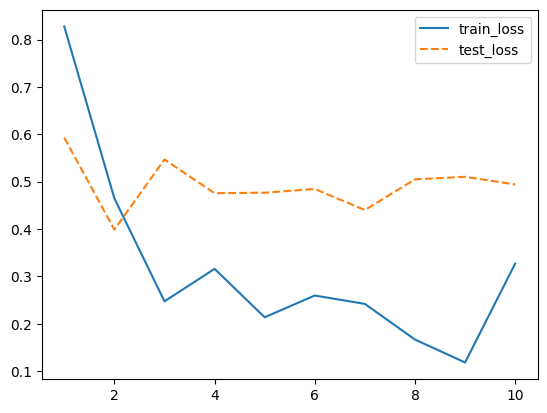

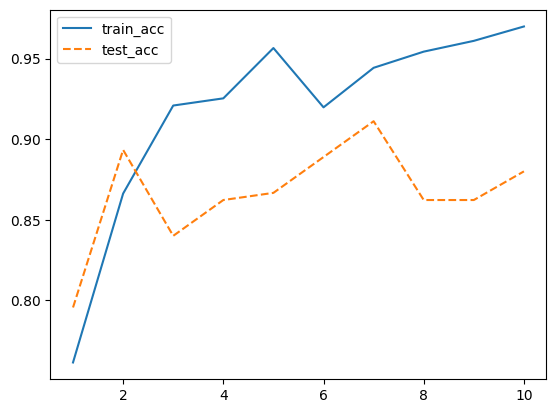

In [16]:
epochs= 10 #一个epoch代表对全部数据训练一遍

train_loss=[]  #每个epoch训练中训练数据集的平均损失被添加到此列表
train_acc=[] #每个epoch训练中训练数据集的平均正确率被添加到此列表
test_loss=[]  #每个epoch训练中测试数据集的平均损失被添加到此列表
test_acc=[] #每个epoch训练中测试数据集的平均正确率被添加到此列表

for epoch in range(epochs):
    #调用train()函数训练
    epoch_loss,epoch_acc=train(train_dl,model,loss_fn,optimizer)
    #调用test()函数测试
    epoch_test_loss,epoch_test_acc=test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    #定义一个打印模版
    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
    #输出当前的epoch的训练集损失、训练集正确率、测试集损失、测试集正确率
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
    
print("Done!")

plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss',ls="--")
plt.legend()
plt.show()

plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc',ls="--")
plt.legend()
plt.show()

In [17]:
#每7个epoch以0.1为衰减系数对学习速率进行衰减
from torch.optim import lr_scheduler
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
exp_lr_scheduler=lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [18]:
# 下面定义训练函数fit()，后续训练时可直接调用
def fit(epochs,train_dl,test_dl,model,loss_fn,optimizer,exp_lr_scheduler=None):
    train_loss=[]
    train_acc=[]
    test_loss=[]
    test_acc=[]
    
    for epoch in range(epochs):
        epoch_loss,epoch_acc=train(train_dl,model,loss_fn,optimizer)
        epoch_test_loss,epoch_test_acc=test(test_dl,model)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
        if exp_lr_scheduler:
            exp_lr_scheduler.step()  # 学习速率衰减
        
        template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
        print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
        
    print("Done!")
    #训练完毕，返回损失和正确率的变化列表
    return train_loss,test_loss,train_acc,test_acc

#执行训练

In [19]:
fit(epoch,train_dl,test_dl,model,loss_fn,optimizer,exp_lr_scheduler)

epoch: 0,train_loss:0.42598,train_acc:91.0%,test_loss:1.10497,test_acc:86.2%
epoch: 1,train_loss:0.39563,train_acc:91.2%,test_loss:0.71850,test_acc:87.1%
epoch: 2,train_loss:0.83786,train_acc:92.4%,test_loss:1.07852,test_acc:85.8%
epoch: 3,train_loss:0.98711,train_acc:89.1%,test_loss:1.18968,test_acc:84.9%
epoch: 4,train_loss:0.78299,train_acc:91.6%,test_loss:1.35353,test_acc:87.6%
epoch: 5,train_loss:0.54784,train_acc:92.3%,test_loss:1.23193,test_acc:85.3%
epoch: 6,train_loss:0.47488,train_acc:96.5%,test_loss:0.84779,test_acc:87.1%
epoch: 7,train_loss:0.07765,train_acc:97.7%,test_loss:0.66062,test_acc:90.7%
epoch: 8,train_loss:0.04269,train_acc:98.4%,test_loss:0.91508,test_acc:90.7%
Done!


([0.42598328966452853,
  0.395629034938713,
  0.8378562967711747,
  0.9871108606212785,
  0.7829862905289446,
  0.5478412376697721,
  0.47488357123261504,
  0.07765431883441945,
  0.04268924834952474],
 [1.1049739865353332,
  0.7184995611508688,
  1.0785247931877773,
  1.1896753508830442,
  1.3535341699915535,
  1.2319332098879385,
  0.8477855606082206,
  0.6606226031833102,
  0.9150787006821095],
 [0.9096989966555183,
  0.9119286510590858,
  0.9241917502787068,
  0.8907469342251951,
  0.9163879598662207,
  0.9230769230769231,
  0.9654403567447045,
  0.9765886287625418,
  0.9843924191750278],
 [0.8622222222222222,
  0.8711111111111111,
  0.8577777777777778,
  0.8488888888888889,
  0.8755555555555555,
  0.8533333333333334,
  0.8711111111111111,
  0.9066666666666666,
  0.9066666666666666])

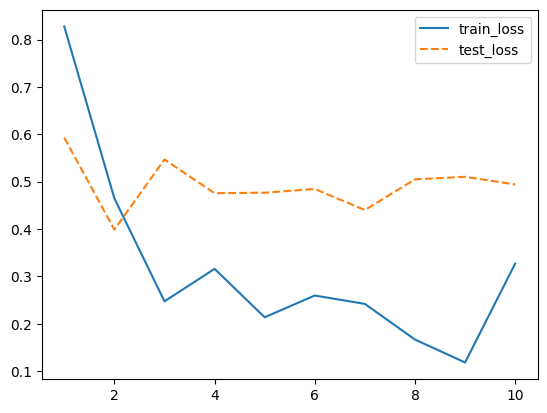

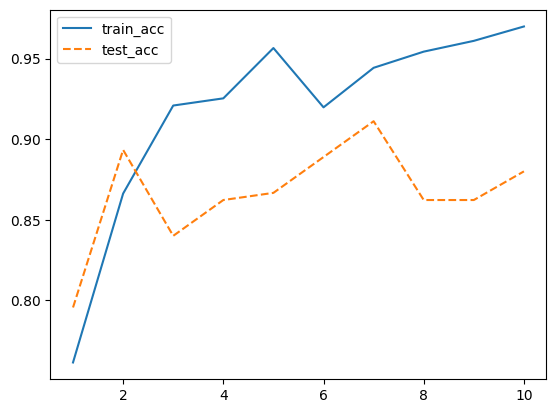

In [20]:
plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss',ls="--")
plt.legend()
plt.show()

plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc',ls="--")
plt.legend()
plt.show()